## Rice type image detection

Zbiór danych : https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

Detekcja gatunku ryzu na podstawie 75 tyś. obrazków ryzu: po 15k obrazków na 5 róznych gatunków ryzu.

In [48]:
!pip install kaggle


In [1]:
#General data operations library
import math
import numpy as np

#The tensorflow library
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys

### Ładowanie obrazków

In [21]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
rice-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
!unzip  -n ./rice-image-dataset.zip  -d Rice_Image_Dataset 
!mv ./Rice_Image_Dataset/Rice_Image_Dataset/ ./rice_dataset

Archive:  ./rice-image-dataset.zip


In [30]:
import pathlib
archive = './rice_dataset'
data_dir = pathlib.Path(archive).with_suffix('')

In [8]:
batch_size = 64
img_height = 250
img_width = 250

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  labels="inferred",  #required for proper class naming
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


In [32]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  labels="inferred",  #required for proper class naming
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


In [33]:
class_names = train_ds.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


2024-10-01 14:39:32.599157: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


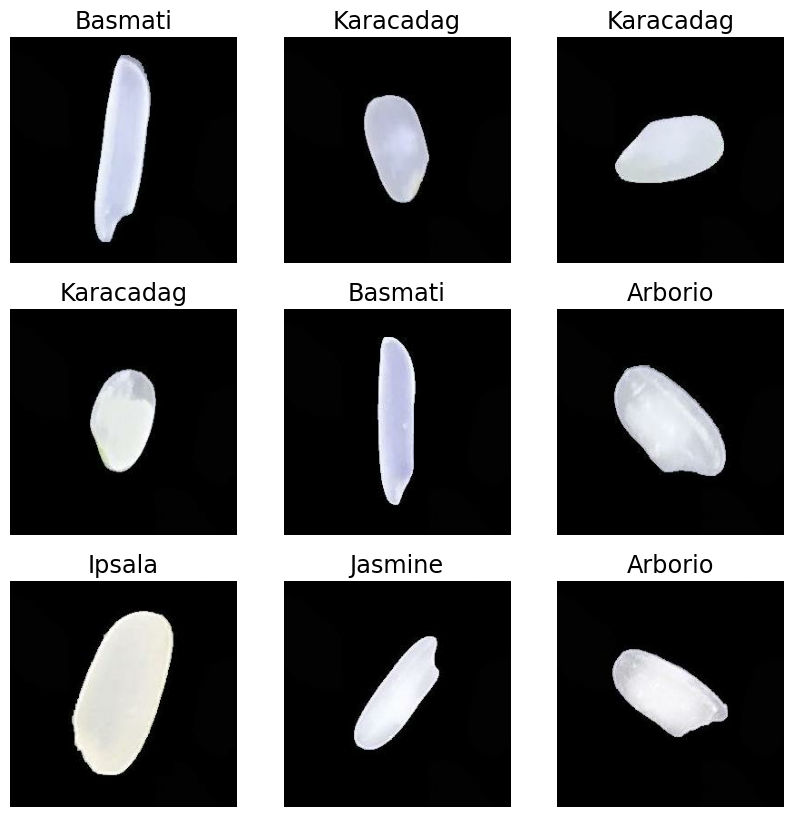

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

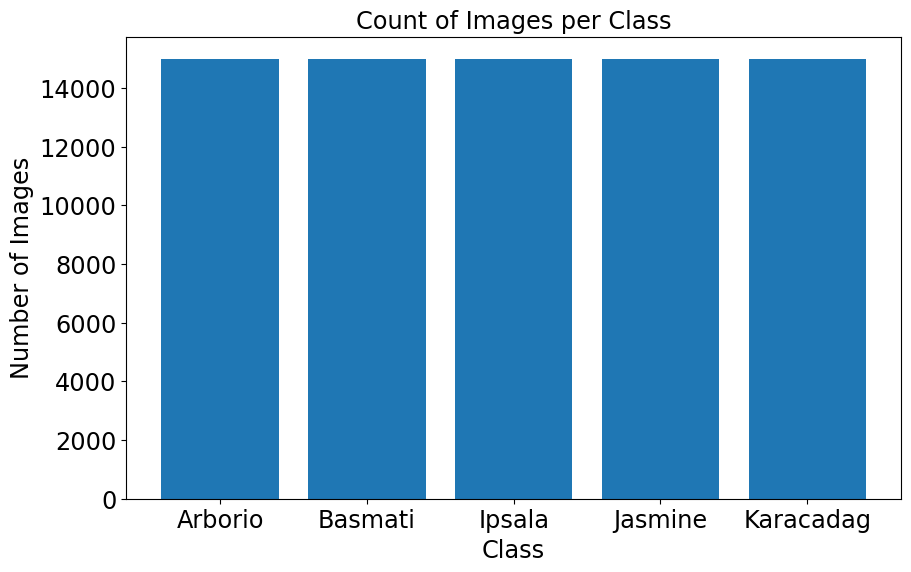

In [35]:
# prompt: histogram with count of each class from class_names
import os
import matplotlib.pyplot as plt

# Get the number of images in each class
class_counts = []
for class_name in class_names:
  count = len([filename for filename in os.listdir(os.path.join(data_dir, class_name)) if filename.endswith('.jpg')])
  class_counts.append(count)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Count of Images per Class")
plt.show()


### Definicja modelu i podział zbioru

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Trening modelu

In [37]:
import os

model_path = './model.keras'

# Check if the model is saved
if os.path.exists(model_path):
    print("Model is saved at the specified path.")
    model = tf.keras.models.load_model(model_path)
else:
    print("No model found at the specified path.")
    model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=3
    )
    model.save(model_path)

Model is saved at the specified path.


### Walidacja modelu

In [39]:
loss, accuracy = model.evaluate(val_ds)

print(f"Model accuracy: {accuracy * 100:.2f}%")
print(f"Model loss: {loss:.3f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.9917 - loss: 0.0275
Model accuracy: 99.26%
Model loss: 0.025


2024-10-01 14:39:55.337381: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0.5, 0.98, 'Comparison of True and Predicted Labels')

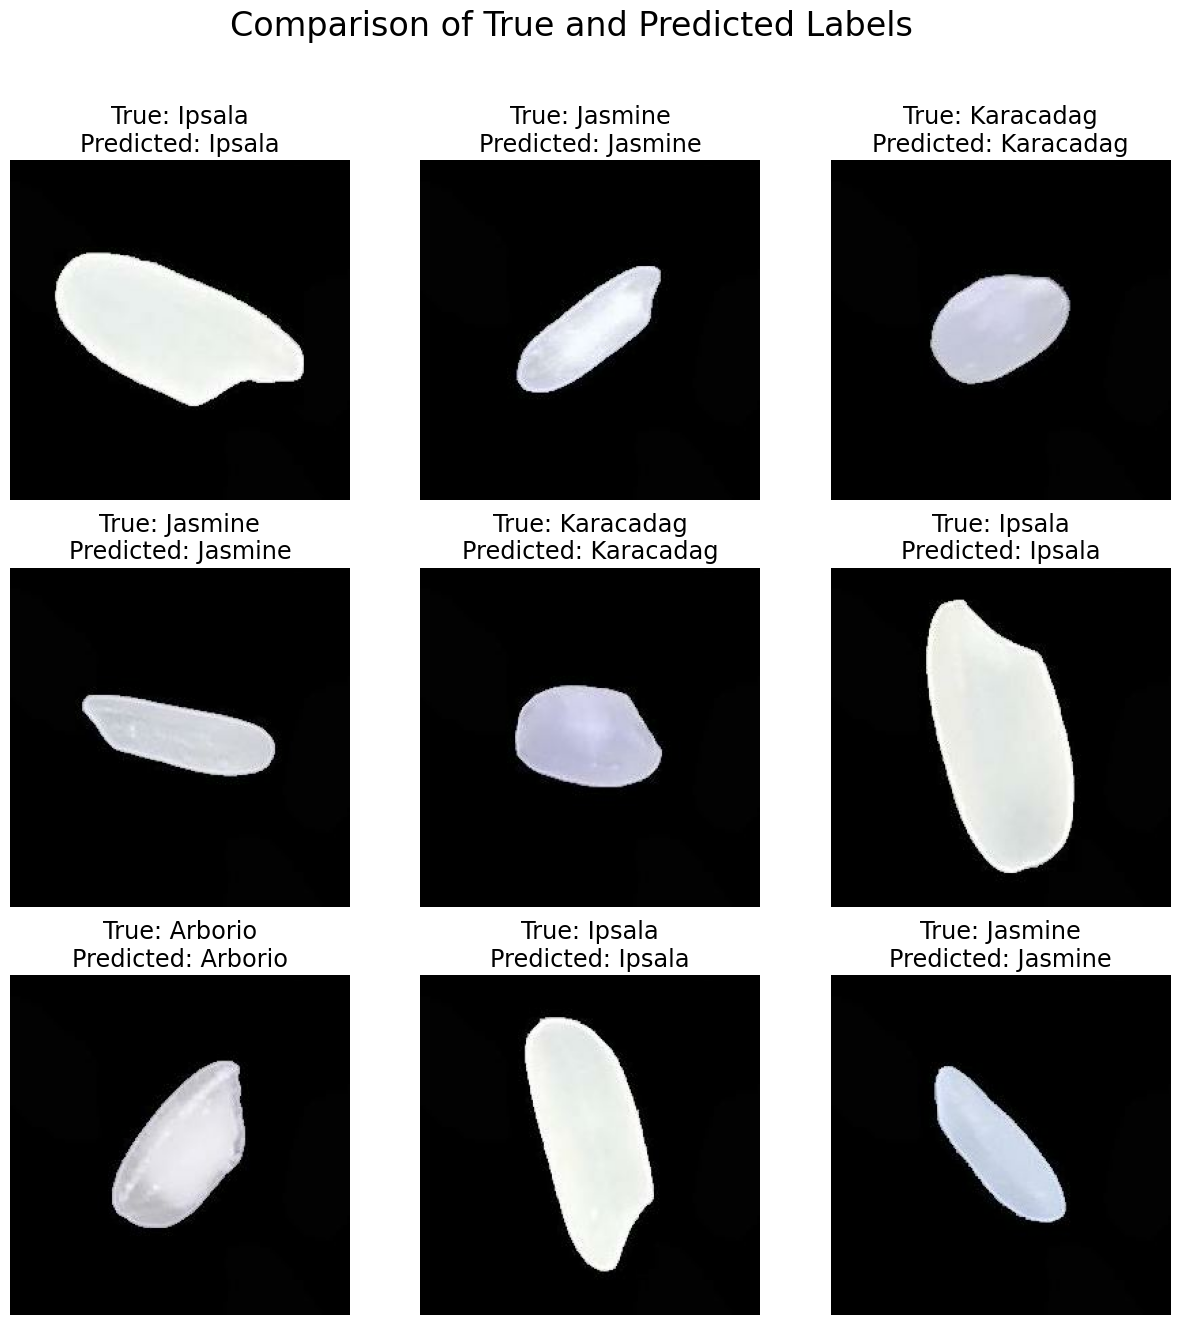

In [38]:
plt.figure(figsize=(15, 15))
imagess = val_ds.unbatch().take(9)
for images, labels in imagess.batch(batch_size=9):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    prediction = model.predict(tf.reshape(images[i], (-1, 250, 250, 3)), verbose=0)
    true_label = class_names[labels[i]]
    predicted_label = np.array(class_names)[np.argmax(prediction, axis=-1)][0]
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis("off")

plt.suptitle("Comparison of True and Predicted Labels", fontsize=24)



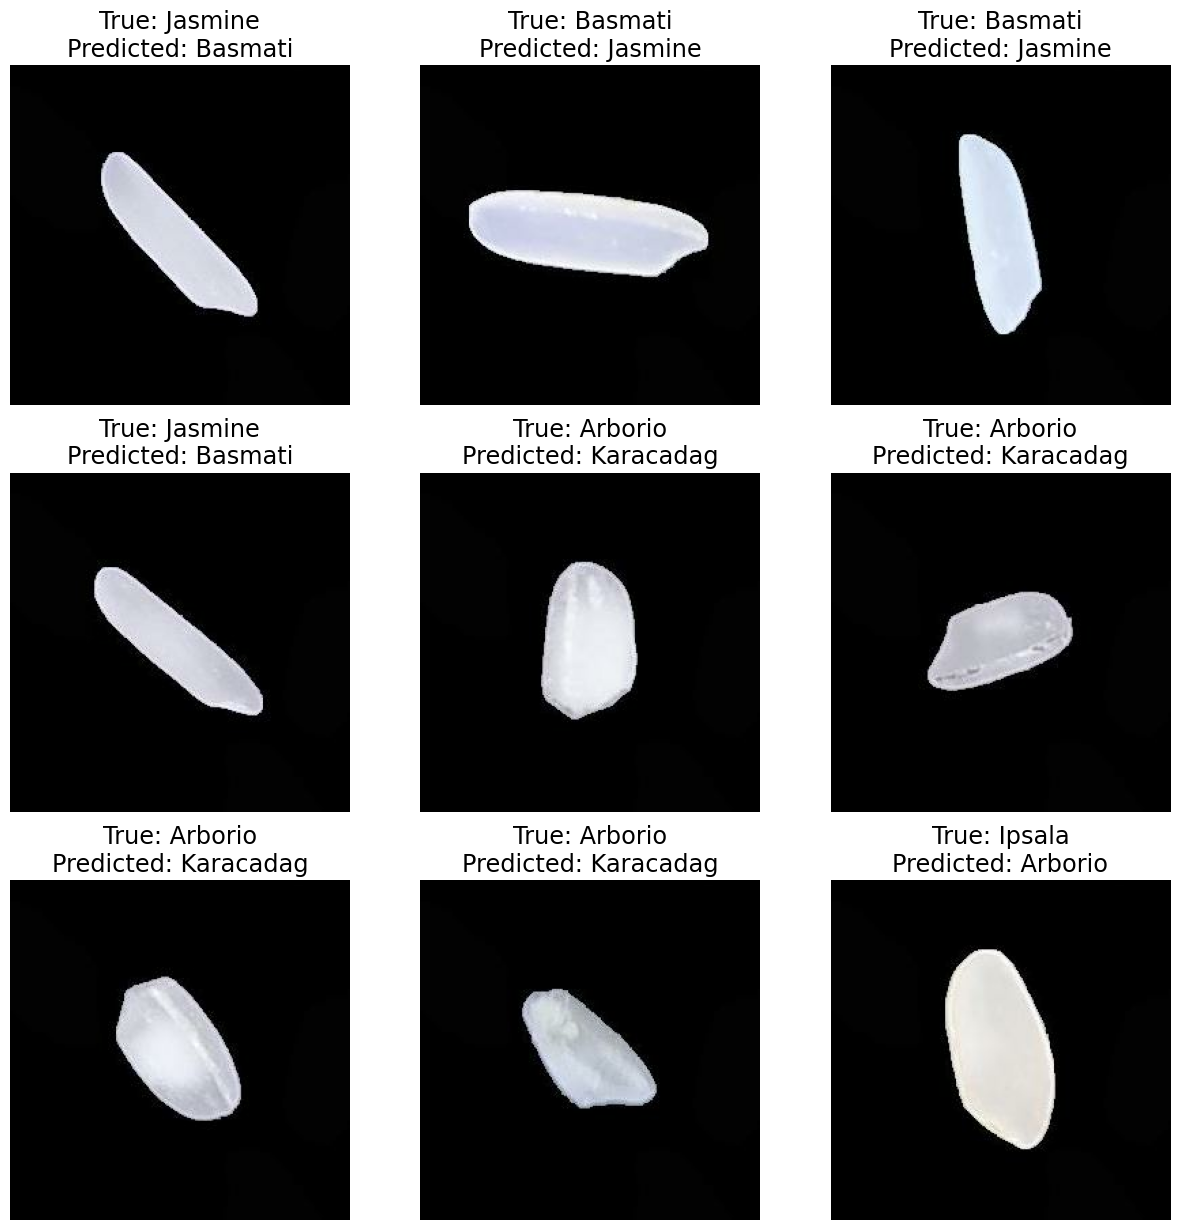

In [ ]:
# Initialize lists to store misclassified images and their labels
wrong_images = []
wrong_true_labels = []
wrong_predicted_labels = []

for images_batch, labels_batch in val_ds:
    # Make predictions on the batch
    predictions = model.predict(images_batch, verbose=0)
    predicted_labels_batch = np.argmax(predictions, axis=1)
    true_labels_batch = labels_batch.numpy()

    # Identify misclassified images
    misclassified_indices = np.where(predicted_labels_batch != true_labels_batch)[0]
    for idx in misclassified_indices:
        wrong_images.append(images_batch[idx].numpy())
        wrong_true_labels.append(true_labels_batch[idx])
        wrong_predicted_labels.append(predicted_labels_batch[idx])
    if len(wrong_images) >= 9:
        break

# Display the first 9 misclassified images
num_wrong = len(wrong_images)
num_to_display = min(9, num_wrong)

plt.figure(figsize=(15, 15))
for i in range(num_to_display):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(wrong_images[i].astype("uint8"))
    true_label = class_names[wrong_true_labels[i]]
    predicted_label = class_names[wrong_predicted_labels[i]]
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis("off")
plt.show()
